In [4]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

### Visualizar la demanda como serie de tiempo

In [5]:
#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
demand_ts = demand_data['demand']

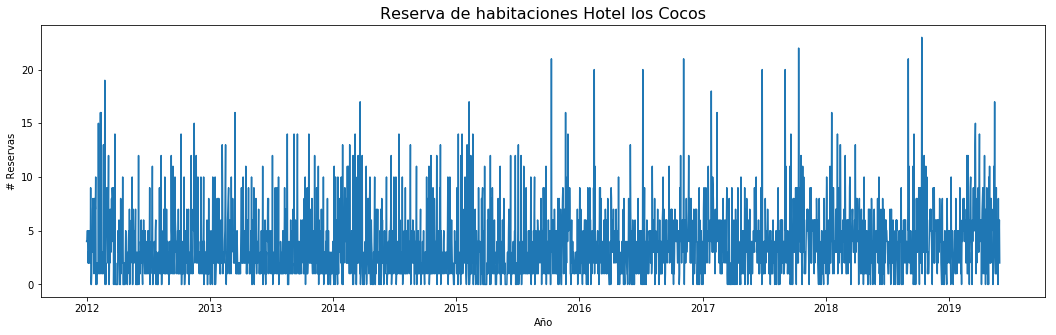

In [6]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [7]:
#agrupamos los dias por meses
#demand_ts  = demand_data['demand'].resample('MS').sum()

### Time Series Decomposition

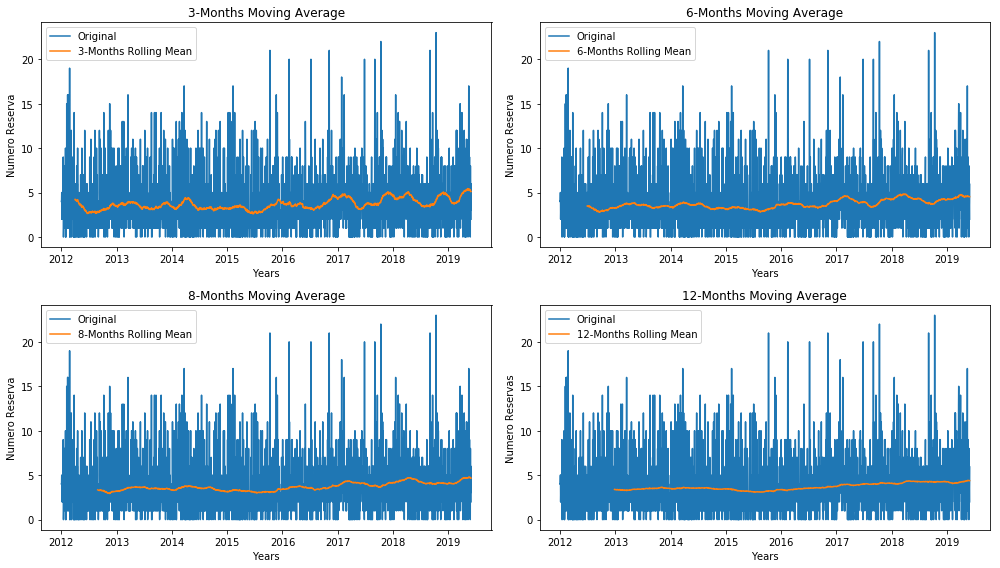

In [8]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(demand_ts.index, demand_ts, label='Original')
axes[0][0].plot(demand_ts.index, demand_ts.rolling(window=90).mean(), label='3-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Numero Reserva")
axes[0][0].set_title("3-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(demand_ts.index, demand_ts, label='Original')
axes[0][1].plot(demand_ts.index, demand_ts.rolling(window=180).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Numero Reserva")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(demand_ts.index, demand_ts, label='Original')
axes[1][0].plot(demand_ts.index, demand_ts.rolling(window=240).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Numero Reserva")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(demand_ts.index, demand_ts, label='Original')
axes[1][1].plot(demand_ts.index, demand_ts.rolling(window=360).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Numero Reservas")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

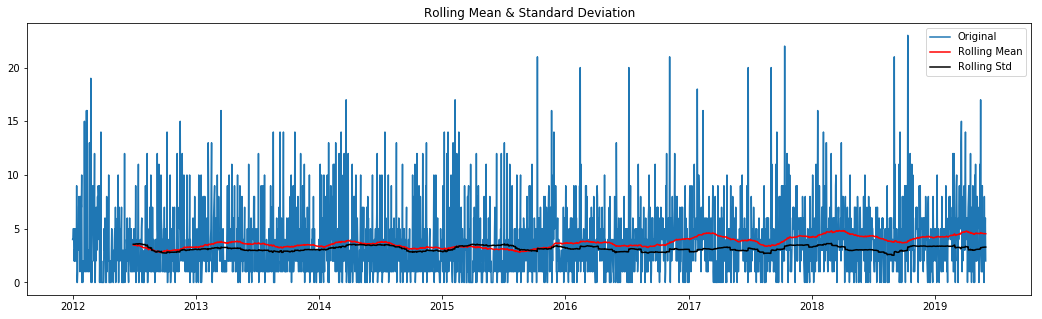

In [9]:
#Determing rolling statistics
rolmean = demand_ts.rolling(window=180).mean()
rolstd = demand_ts.rolling(window=180).std()

#Plot rolling statistics:
orig = plt.plot(demand_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean',color='red')
std = plt.plot(rolstd, label = 'Rolling Std',color='black')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(demand_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -8.44459
p-value                          0.00000
#lags Used                      16.00000
Number of Observations Used   2689.00000
Critical Value (1%)             -3.43278
Critical Value (5%)             -2.86262
Critical Value (10%)            -2.56734
dtype: float64


### Seasonality – Time Series Decomposition

In [11]:
monthly_demand_data = pd.pivot_table(demand_data, values = "demand", columns = "year", index = "month" ,aggfunc=[np.sum])
monthly_demand_data = monthly_demand_data.reindex(index = ['ENE','FEB','MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEPT', 'OCT', 'NOV', 'DIC'])
monthly_demand_data

sum                                                              \
year       2012      2013      2014      2015      2016      2017      2018   
month                                                                         
ENE   126.00000 114.00000 114.00000 114.00000  94.00000 174.00000 150.00000   
FEB   127.00000 120.00000 135.00000 110.00000 120.00000 123.00000 149.00000   
MAR   128.00000 111.00000 144.00000  86.00000 102.00000  93.00000 143.00000   
ABR    72.00000 110.00000  89.00000  86.00000 120.00000  86.00000 125.00000   
MAY    92.00000 102.00000  97.00000  82.00000  92.00000 112.00000 103.00000   
JUN    86.00000  98.00000 102.00000  83.00000  89.00000 126.00000 117.00000   
JUL    78.00000  96.00000  97.00000  99.00000 103.00000 108.00000  97.00000   
AGO   100.00000  96.00000 101.00000 102.00000 109.00000 100.00000 102.00000   
SEPT  106.00000 110.00000  82.00000 112.00000 134.00000 140.00000 141.00000   
OCT    90.00000 134.00000 112.00000 115.00000 129.00000 184.00000 181.00000   
NOV   137.00000 107.00000 100.00000 144.00000 166.00000 136.00000 136.00000   
DIC    94.00000  73.00000  83.00000  98.00000 102.00000 110.00000 110.00000   

                 
year       2019  
month            
ENE   104.00000  
FEB   144.00000  
MAR   184.00000  
ABR   141.00000  
MAY   142.00000  
JUN         nan  
JUL         nan  
AGO         nan  
SEPT        nan  
OCT         nan  
NOV         nan  
DIC         nan

In [12]:
#monthly_demand_data.plot()

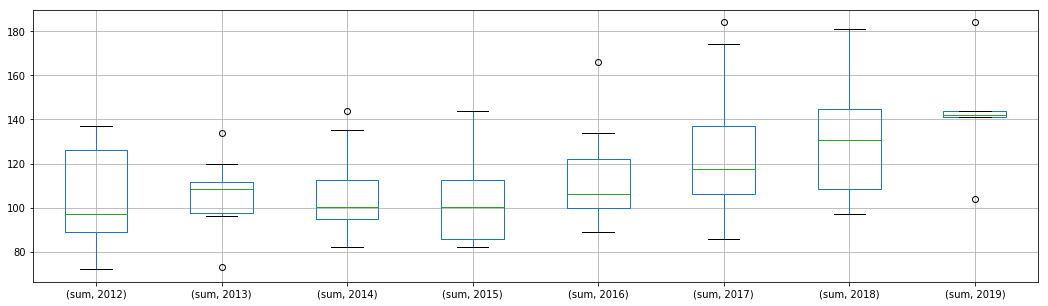

In [13]:
monthly_demand_data.boxplot()

### Irregular Remainder – Time Series Decomposition

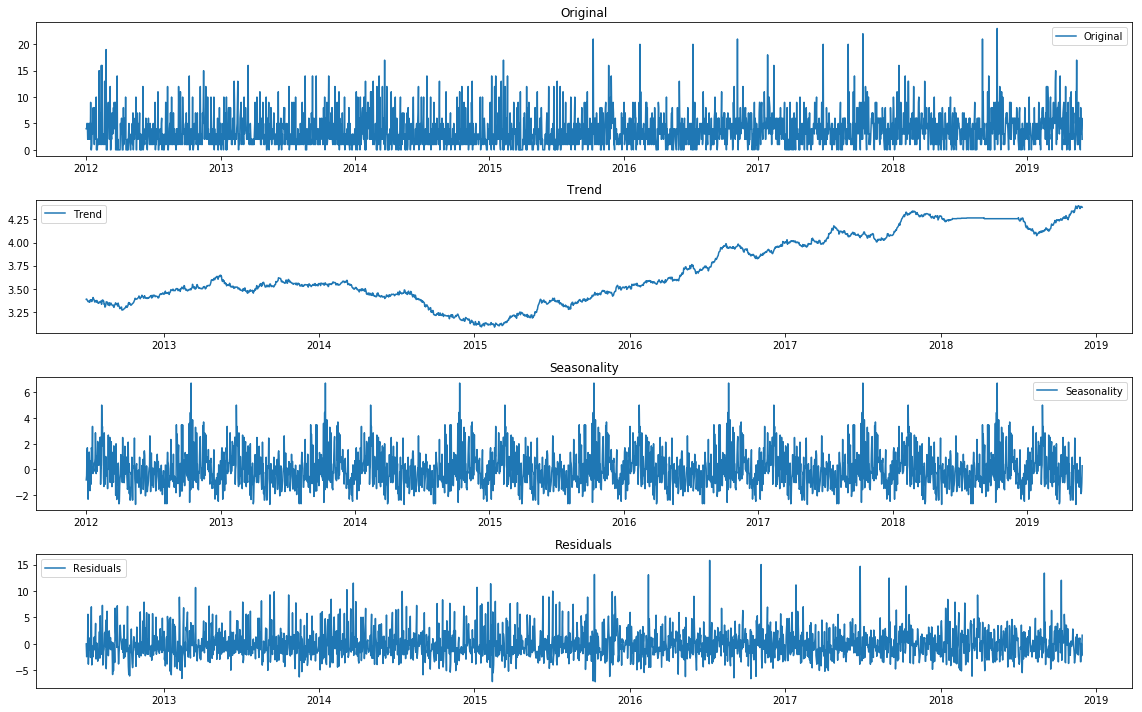

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(demand_ts, freq=365)

plt.figure(figsize = (16,10))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Original')
plt.plot(demand_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.title('Trend')
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.title('Seasonality')
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.title('Residuals')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

### Diferenciar los datos para hacer que sean estacionarios en la media (eliminar tendencia) 

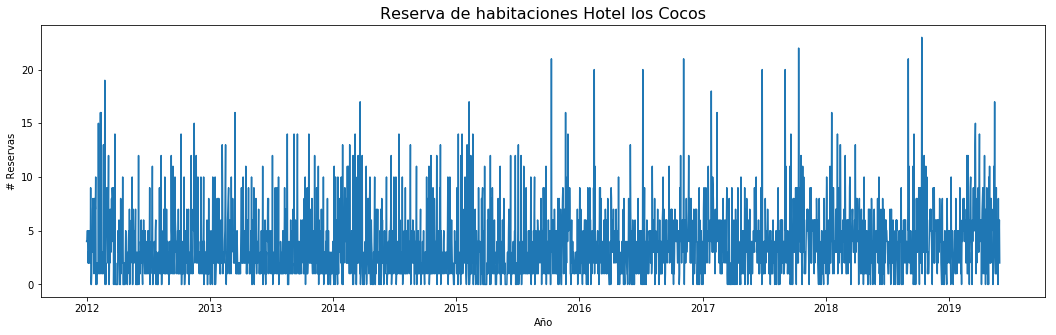

In [15]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

Text(0, 0.5, 'Demand')

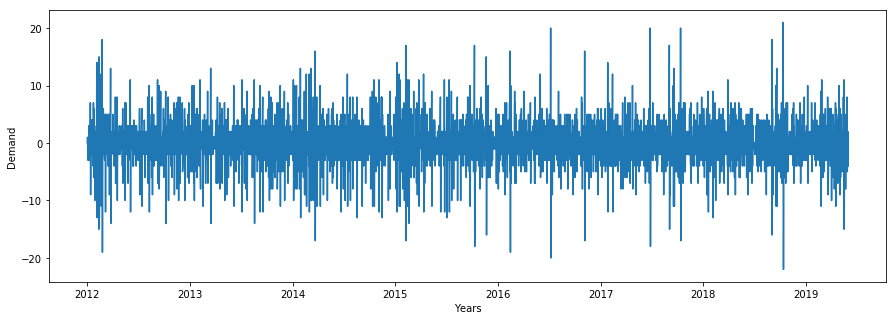

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(demand_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Demand')

### Log transformation para hacer que los datos sean estacionarios en varianza 

Text(0, 0.5, 'Log (Demand)')

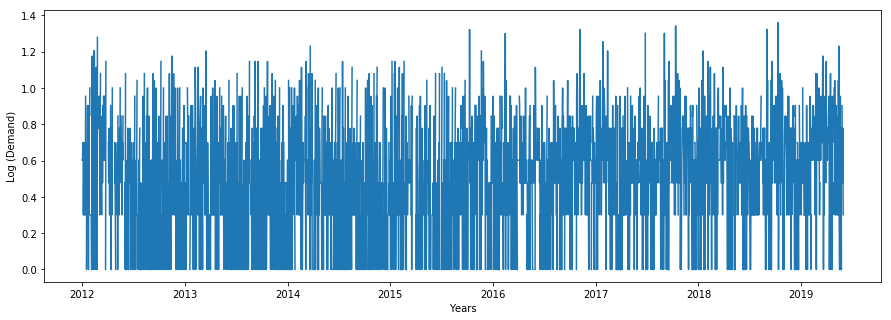

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(demand_ts))
plt.xlabel('Years')
plt.ylabel('Log (Demand)')

### Difference log transform para hacer que los datos sean estacionarios tanto en la media como en varianza

Text(0, 0.5, 'Differenced Log Demand')

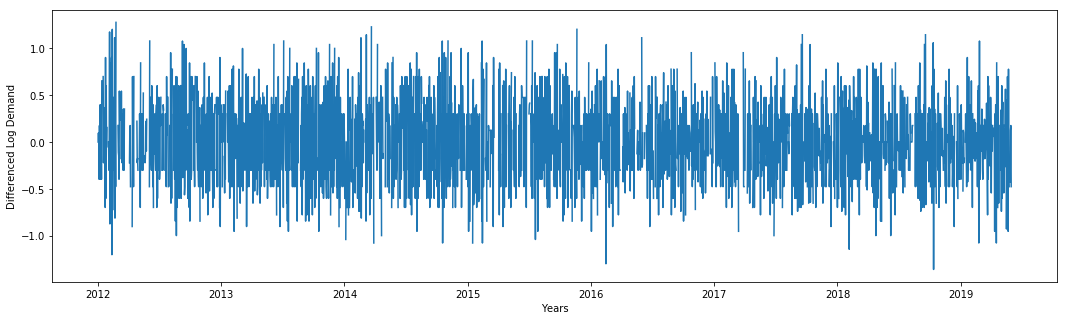

In [18]:
plt.figure(figsize=(18, 5))
plt.plot(np.log10(demand_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log Demand')

In [19]:
#ts_decompose = residual
#ts_decompose.dropna(inplace=True)

### Plot ACF and PACF to identify potential AR and MA model

In [20]:
demand_ts_log = np.log10(demand_ts)
demand_ts_log.dropna(inplace=True)
demand_ts_log.head(8)

time
2012-01-01   0.60206
2012-01-02   0.60206
2012-01-03   0.69897
2012-01-04   0.69897
2012-01-05   0.30103
2012-01-06   0.47712
2012-01-07   0.30103
2012-01-08   0.69897
Name: demand, dtype: float64

In [21]:
demand_ts_log_diff = demand_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
demand_ts_log_diff.dropna(inplace=True)

demand_ts_log_diff.head(12)

time
2012-01-02    0.00000
2012-01-03    0.09691
2012-01-04    0.00000
2012-01-05   -0.39794
2012-01-06    0.17609
2012-01-07   -0.17609
2012-01-08    0.39794
2012-01-09   -0.39794
2012-01-10    0.39794
2012-01-11    0.00000
2012-01-12   -0.39794
2012-01-13    0.65321
Name: demand, dtype: float64

In [22]:
demand_ts_diff = demand_ts.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
demand_ts_diff.dropna(inplace=True)
demand_ts_diff.head(12)

time
2012-01-02    0.00000
2012-01-03    1.00000
2012-01-04    0.00000
2012-01-05   -3.00000
2012-01-06    1.00000
2012-01-07   -1.00000
2012-01-08    3.00000
2012-01-09   -3.00000
2012-01-10    3.00000
2012-01-11    0.00000
2012-01-12   -3.00000
2012-01-13    7.00000
Name: demand, dtype: float64

In [23]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(demand_ts_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -16.20214
p-value                          0.00000
#lags Used                      27.00000
Number of Observations Used   2677.00000
Critical Value (1%)             -3.43280
Critical Value (5%)             -2.86262
Critical Value (10%)            -2.56735
dtype: float64


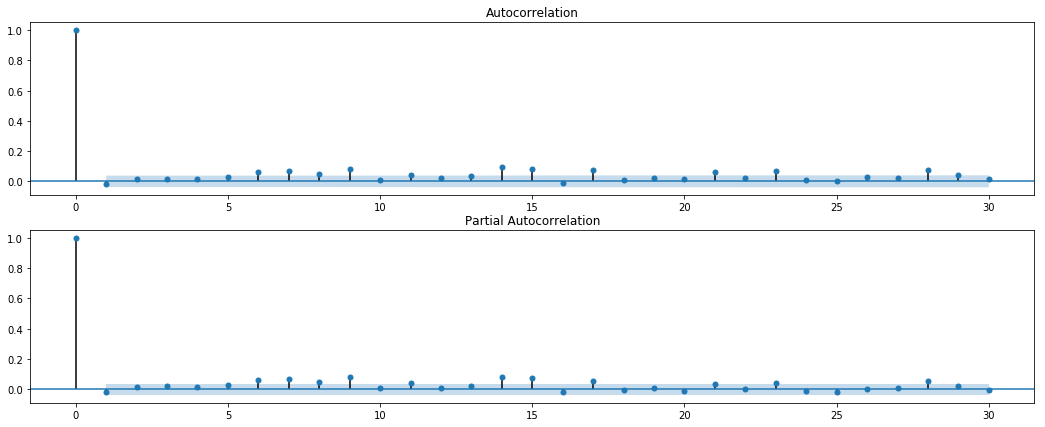

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure(figsize=(18, 7))
pyplot.subplot(211)
plot_acf(demand_ts, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(demand_ts, ax=pyplot.gca(), lags = 30)
pyplot.show()
#plt.tight_layout()

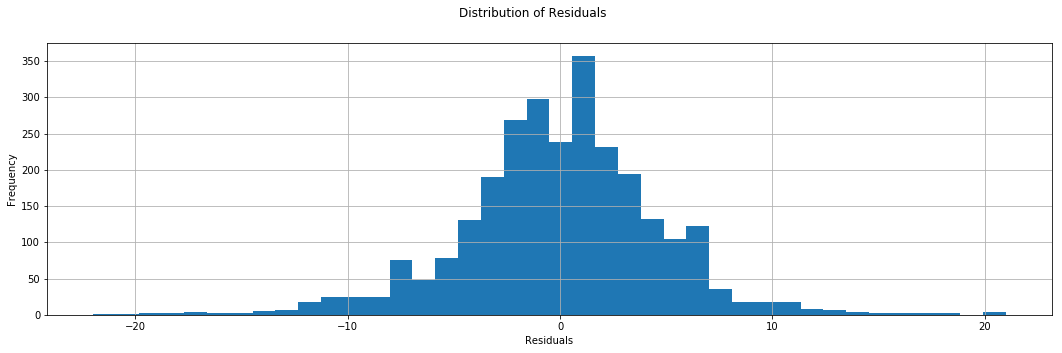

In [25]:
fig,ax = plt.subplots()
ax.hist(demand_ts_diff, bins=40)
ax.grid(True)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
fig.suptitle("Distribution of Residuals");

### Identificación del mejor modelo de ajuste ARIMA 

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [30]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(demand_ts,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 model - AIC:13907.050867679467


In [98]:
best_model = sm.tsa.statespace.SARIMAX(demand_ts,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 1, 1, 30),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [99]:
print(best_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                 2706
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 30)   Log Likelihood               -6863.406
Date:                            Tue, 02 Jul 2019   AIC                          13734.812
Time:                                    18:47:34   BIC                          13758.331
Sample:                                         0   HQIC                         13743.326
                                           - 2706                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0481      0.021     -2.291      0.022      -0.089      -0.007
ma.L1         -0.9749      0.005   

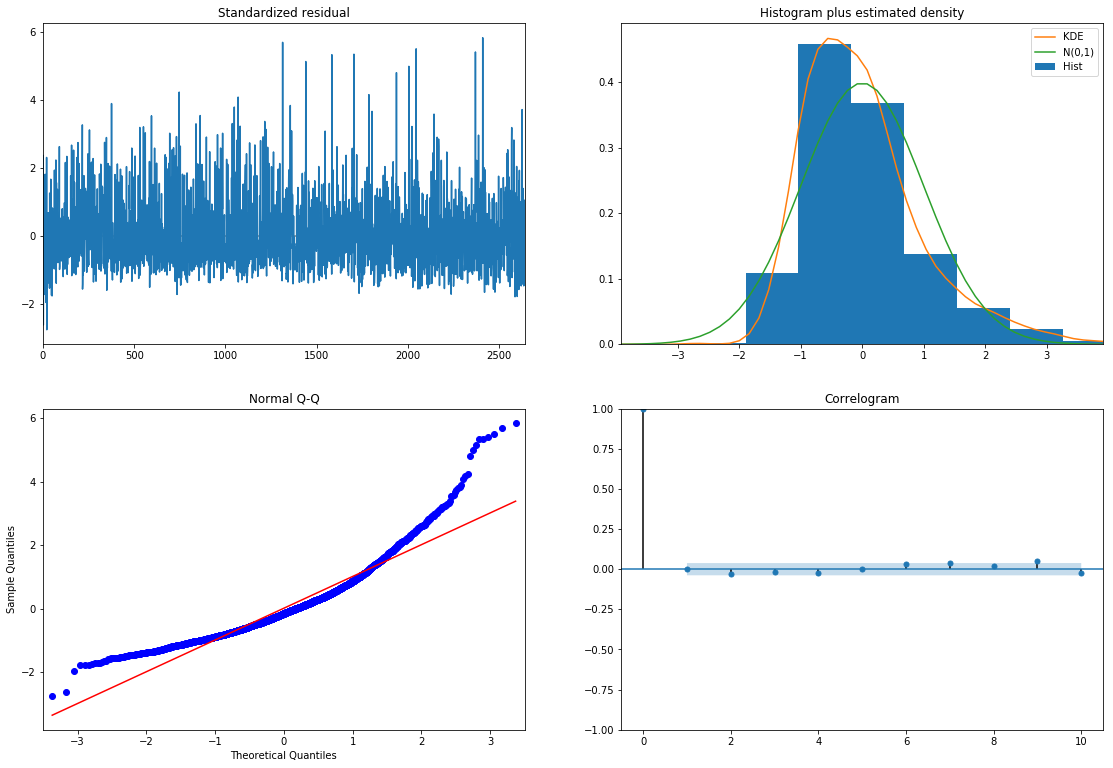

In [100]:
best_results.plot_diagnostics(figsize=(19, 13))
plt.show()

### Predict demand on in-sample date using the best fit ARIMA model

In [101]:
pred = best_results.get_prediction(start=1460, dynamic=False)
pred_ci = pred.conf_int()


In [102]:
print(pred.predicted_mean)

time
2016-01-01   3.62692
2016-01-02   4.41226
2016-01-03   2.99972
2016-01-04   4.08455
2016-01-05   4.44581
2016-01-06   3.09171
2016-01-07   4.42428
2016-01-08   3.55349
               ...  
2019-05-24   5.02165
2019-05-25   5.68348
2019-05-26   4.63337
2019-05-27   4.61097
2019-05-28   4.55097
2019-05-29   4.63843
2019-05-30   5.23914
2019-05-31   4.66088
Length: 1246, dtype: float64


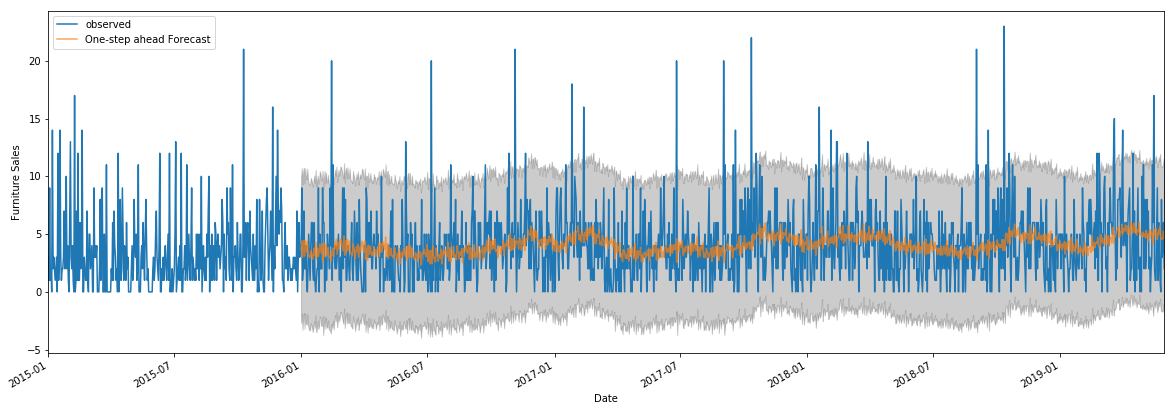

<Figure size 1296x360 with 0 Axes>

In [103]:
ax = demand_ts['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()
plt.tight_layout()

### Forecast sales using the best fit ARIMA model

In [104]:
FORECAST = 240
pred_uc = best_results.get_forecast(steps=FORECAST)
pred_ci = pred_uc.conf_int()

In [105]:
futureDates = pd.date_range(start = '2019-05-30', periods=FORECAST, freq='D')
pred_ci.index = futureDates
mean= pred_uc.predicted_mean

In [106]:
futureDF = pd.DataFrame(mean.values, index=futureDates)
futureDF

0
2019-05-30 4.77278
2019-05-31 4.59031
2019-06-01 4.36277
2019-06-02 4.82547
2019-06-03 4.41512
2019-06-04 4.79913
2019-06-05 4.06405
2019-06-06 4.67435
...            ...
2020-01-17 4.82196
2020-01-18 5.35944
2020-01-19 4.30377
2020-01-20 4.51664
2020-01-21 4.67468
2020-01-22 4.56593
2020-01-23 5.25624
2020-01-24 4.67191

[240 rows x 1 columns]

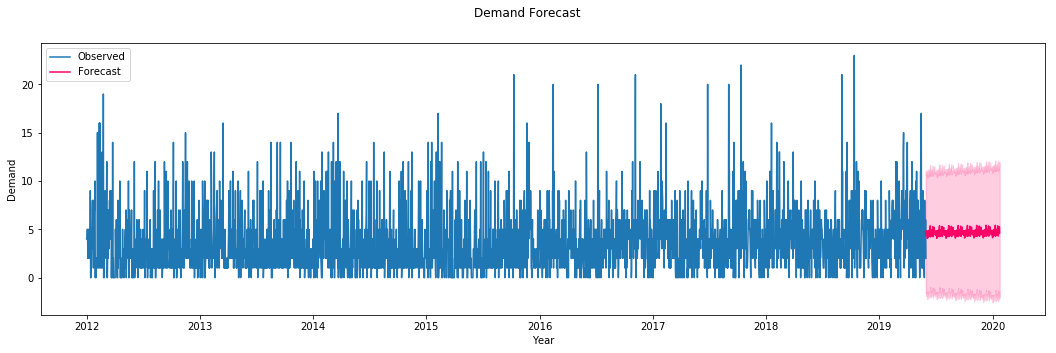

In [107]:
fig,ax = plt.subplots()
ax.plot(demand_ts, label="Observed")
ax.plot(futureDF, label='Forecast', color='#ff0066');

  # draw confidence bound
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.2);
 
ax.set_xlabel("Year")
ax.set_ylabel("Demand")
 
ax.legend(loc='upper left')
fig.suptitle("Demand Forecast");

In [128]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(demand_ts_truth)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(demand_ts_forecasted, demand_ts_truth)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
# Extract the predicted and true values of our time series
demand_ts_forecasted = pred_dynamic.predicted_mean
demand_ts_truth = demand_ts_log['2016-01-01':]


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mad = demand_ts_forecasted.mad()
mad

In [ ]:
# Mean square error
mse = ((demand_ts_forecasted - demand_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

mape = mean_absolute_percentage_error(demand_ts_truth, demand_ts_forecasted)
print('The mean_absolute_percentage_error of our forecasts is {}'.format(round(mape, 4)))